In [1]:
import re
import string
import logging

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from urllib.parse import urlparse
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier, Perceptron
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#from tldextract import extract as tld_extract
#from tld import get_tld, is_tld
#from tld.exceptions import TldDomainNotFound, TldBadUrl, TldIOError

from colorama import Fore
from datetime import datetime
from plotly.subplots import make_subplots
from plotly import graph_objects as go
from wordcloud import WordCloud
from gensim.models import Word2Vec

In [2]:
urls_data = pd.read_csv('/kaggle/input/phising-sites/malicious_phish.csv')
urls_data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [3]:
urls_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [4]:
urls_data.columns.isnull()

array([False, False])

In [5]:
urls_data.dtypes

url     object
type    object
dtype: object

In [6]:
urls_data.type

0           phishing
1             benign
2             benign
3         defacement
4         defacement
             ...    
651186      phishing
651187      phishing
651188      phishing
651189      phishing
651190      phishing
Name: type, Length: 651191, dtype: object

In [7]:
urls_data['type'].value_counts()

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

In [8]:
count = urls_data['type'].value_counts()
colors = [
    '#FF6633', '#FFB399', '#FF33FF', '#FFFF99', '#00B3E6',
    '#E6B333', '#3366E6', '#999966', '#99FF99', '#B34D4D'
]
fig = go.Figure(data=[go.Bar(x=count.index, y=count, marker=dict(color=colors))])
fig.update_layout(
    xaxis_title='Types',
    yaxis_title='Count',
    title='Count of Different Types of URLs',
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white')
)
fig.update_xaxes(tickfont=dict(color='white'))
fig.update_yaxes(tickfont=dict(color='white'))
fig.show()

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

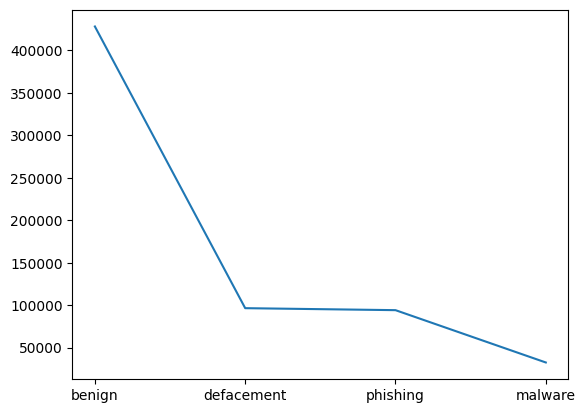

In [10]:
plt.plot(urls_data['type'].value_counts())

<BarContainer object of 4 artists>

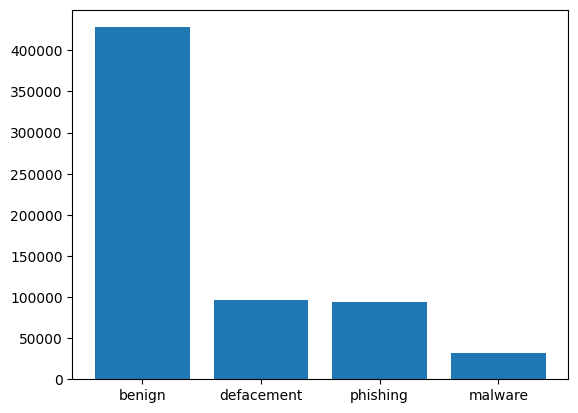

In [11]:
counts=urls_data['type'].value_counts()
plt.bar(x=counts.index,height=counts)

In [12]:
urls_data['url']=urls_data['url'].replace('www.','',regex=True)
urls_data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [13]:
urls_data['type'].value_counts()

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

In [14]:
urls_data["url_type"] = urls_data["type"].replace({
    'benign':0,
    'defacement':1,
    'phishing':2,
    'malware':3
});

In [15]:
urls_data.head()

,url,type,url_type
0,br-icloud.com.br,phishing,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1


In [16]:
def get_url_length(url):
    # Remove common prefixes
    prefixes = ['http://', 'https://']
    for prefix in prefixes:
        if url.startswith(prefix):
            url = url[len(prefix):]

    # Remove 'www.' if present
    url = url.replace('www.', '')

    # Return the length of the remaining URL
    return len(url)

In [17]:
urls_data['url_len'] = urls_data['url'].apply(lambda x: get_url_length(str(x)))

In [18]:
urls_data.head()

,url,type,url_type,url_len
0,br-icloud.com.br,phishing,2,16
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228


In [19]:
import string

def count_letters(url):
    num_letters=sum(char.isalpha() for char in url)
    return num_letters

def count_digits(url):
    num_digits=sum(char.isdigit() for char in url)
    return num_digits

def count_special_characters(url):
    special_characters=set(string.punctuation)
    num_special_character=sum(char in special_characters for char in url)
    return num_special_character

In [20]:
urls_data['letter_counts']=urls_data['url'].apply(lambda x:count_letters(x))
urls_data['digits_counts']=urls_data['url'].apply(lambda x:count_digits(x))
urls_data['special_characters_count']=urls_data['url'].apply(lambda x:count_special_characters(x))
urls_data.head()

,url,type,url_type,url_len,letter_counts,digits_counts,special_characters_count
0,br-icloud.com.br,phishing,2,16,13,0,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,29,1,5
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,25,1,5
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,60,7,17
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,199,22,14


In [21]:
import re
def has_shortening_service(url):
    pattern = re.compile(r'https?://(?:www\.)?(?:\w+\.)*(\w+)\.\w+')
    match = pattern.search(url)
    
    if match:
        domain = match.group(1)
        common_shortening_services = ['bit', 'goo', 'tinyurl', 'ow', 't', 'is',
                                      'cli', 'yfrog', 'migre', 'ff', 'url4', 'twit',
                                      'su', 'snipurl', 'short', 'BudURL', 'ping', 
                                      'post', 'Just', 'bkite', 'snipr', 'fic', 
                                      'loopt', 'doiop', 'short', 'kl', 'wp', 
                                      'rubyurl', 'om', 'to', 'bit', 't', 'lnkd', 
                                      'db', 'qr', 'adf', 'goo', 'bitly', 'cur', 
                                      'tinyurl', 'ow', 'bit', 'ity', 'q', 'is', 
                                      'po', 'bc', 'twitthis', 'u', 'j', 'buzurl','cutt', 'u', 'yourls', 'x', 'prettylinkpro', 
                                      'scrnch', 'filoops', 'vzturl', 'qr', '1url', 
                                      'tweez', 'v', 'tr', 'link', 'zip']
        
        if domain.lower() in common_shortening_services:
            return 1
    return 0 
                

In [22]:
urls_data['shortend']=urls_data['url'].apply(lambda x:has_shortening_service(x))
urls_data.head()

,url,type,url_type,url_len,letter_counts,digits_counts,special_characters_count,shortend
0,br-icloud.com.br,phishing,2,16,13,0,3,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,29,1,5,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,25,1,5,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,60,7,17,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,199,22,14,0


In [23]:
from urllib.parse import urlparse
def abnormal_url(url):
    parsed_url = urlparse(url)
    netloc = parsed_url.netloc
    if netloc:
        netloc = str(netloc)
        match = re.search(netloc, url)
        if match:
            return 1
    return 0

In [24]:
urls_data['abnormal_url']=urls_data['url'].apply(lambda x:abnormal_url(x))
urls_data.head()

,url,type,url_type,url_len,letter_counts,digits_counts,special_characters_count,shortend,abnormal_url
0,br-icloud.com.br,phishing,2,16,13,0,3,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,29,1,5,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,25,1,5,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,60,7,17,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,199,22,14,0,1


In [25]:
def abnormal_url(url):
    parsed_url = urlparse(url)
    netloc = parsed_url.netloc
    if netloc:
        netloc = str(netloc)
        match = re.search(netloc, url)
        if match:
            return 1
    return 0

In [26]:
urls_data['abnormal_url']  = urls_data['url'].apply(lambda x: abnormal_url(x))

In [27]:
urls_data.head()

,url,type,url_type,url_len,letter_counts,digits_counts,special_characters_count,shortend,abnormal_url
0,br-icloud.com.br,phishing,2,16,13,0,3,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,29,1,5,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,25,1,5,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,60,7,17,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,199,22,14,0,1


In [28]:
def secure_http(url):
    return int(urlparse(url).scheme == 'https')

In [29]:
urls_data['secure_http']  = urls_data['url'].apply(lambda x: secure_http(x))

In [30]:
urls_data.head()

,url,type,url_type,url_len,letter_counts,digits_counts,special_characters_count,shortend,abnormal_url,secure_http
0,br-icloud.com.br,phishing,2,16,13,0,3,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,29,1,5,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,25,1,5,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,60,7,17,0,1,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,199,22,14,0,1,0


In [31]:
import ipaddress
def have_ip_address(url):
    try:
        parsed_url = urlparse(url)
        if parsed_url.hostname:
            ip = ipaddress.ip_address(parsed_url.hostname)
            return isinstance(ip, (ipaddress.IPv4Address, ipaddress.IPv6Address))
    except ValueError:
        pass  # Invalid hostname or IP address

    return 0

In [32]:
urls_data['have_ip']  = urls_data['url'].apply(lambda x: have_ip_address(x))


In [33]:
urls_data.head()


,url,type,url_type,url_len,letter_counts,digits_counts,special_characters_count,shortend,abnormal_url,secure_http,have_ip
0,br-icloud.com.br,phishing,2,16,13,0,3,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,29,1,5,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,25,1,5,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,60,7,17,0,1,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,199,22,14,0,1,0,0


In [34]:
urls_data.isnull().sum()

url                         0
type                        0
url_type                    0
url_len                     0
letter_counts               0
digits_counts               0
special_characters_count    0
shortend                    0
abnormal_url                0
secure_http                 0
have_ip                     0
dtype: int64

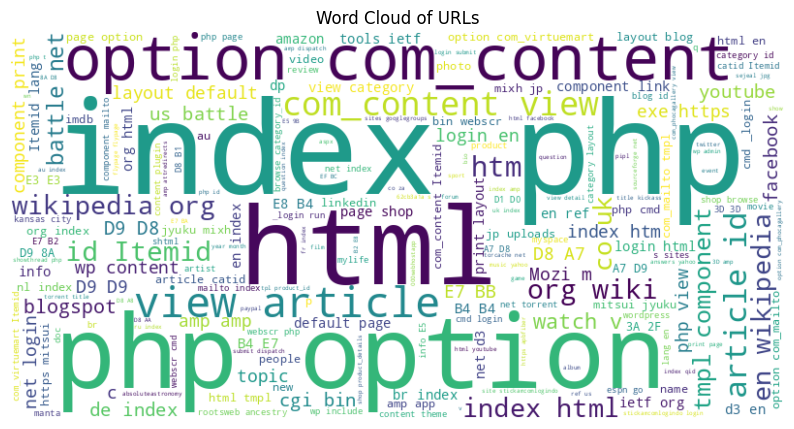

In [35]:
# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(urls_data['url']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of URLs')
plt.show()

In [36]:
# Histogram
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Histogram(x=urls_data['url_len'], nbinsx=100))

fig.update_layout(
    title='Distribution of URL Lengths',
    xaxis_title='URL Length',
    yaxis_title='Count',
    template='plotly_dark',
    font=dict(color='white')
)

fig.show()

In [37]:
# Bar chart for 'type' column
type_counts = urls_data['type'].value_counts()
fig = go.Figure(data=[go.Bar(x=type_counts.index, y=type_counts.values)])
fig.update_layout(title='Frequency of URL Types',
                  xaxis_title='URL Type',
                  yaxis_title='Count',
                  template='plotly_dark',
                  font=dict(color='white'),
                  showlegend=False)
fig.show()

In [38]:
# Pie chart for 'url_type' column
url_type_counts = urls_data['url_type'].value_counts()
fig = go.Figure(data=[go.Pie(labels=url_type_counts.index, values=url_type_counts.values)])
fig.update_layout(title='Distribution of URL Types',
                  template='plotly_dark',
                  font=dict(color='white'),
                  showlegend=True)
fig.show()

In [39]:
urls_data.head()

,url,type,url_type,url_len,letter_counts,digits_counts,special_characters_count,shortend,abnormal_url,secure_http,have_ip
0,br-icloud.com.br,phishing,2,16,13,0,3,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,29,1,5,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,25,1,5,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,77,60,7,17,0,1,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,228,199,22,14,0,1,0,0


In [40]:
data = urls_data.drop(columns=['url','type'])

In [41]:
data.head()

,url_type,url_len,letter_counts,digits_counts,special_characters_count,shortend,abnormal_url,secure_http,have_ip
0,2,16,13,0,3,0,0,0,0
1,0,35,29,1,5,0,0,0,0
2,0,31,25,1,5,0,0,0,0
3,1,77,60,7,17,0,1,0,0
4,1,228,199,22,14,0,1,0,0


In [42]:
x = data.drop(columns=['url_type'])
y = data['url_type']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3, random_state=42)


In [43]:
print(f"X_train Shape : {x_train.shape}")
print(f"Y_train Shape : {y_train.shape}")
print(f"X_test  Shape : {x_test.shape}")
print(f"Y_test  Shape : {y_test.shape}")

X_train Shape : (455833, 8)
Y_train Shape : (455833,)
X_test  Shape : (195358, 8)
Y_test  Shape : (195358,)


In [44]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    KNeighborsClassifier(),
    ExtraTreesClassifier(),
    GaussianNB()
]

In [45]:
results = []
for classifier in classifiers:
    pipeline = Pipeline([
        ('classifier', classifier)
    ])
    scores = cross_val_score(pipeline, x, y, cv=2, scoring='accuracy')
    y_pred = cross_val_predict(pipeline, x, y, cv=2)
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred, average='weighted')
    precision = precision_score(y, y_pred, average='weighted', zero_division=1) 
    f1 = f1_score(y, y_pred, average='weighted')
    results.append((classifier.__class__.__name__, accuracy, recall, precision, f1))

In [46]:
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Recall', 'Precision', 'F1-Score'])
results = results.sort_values(by='Accuracy', ascending=False)
results.head()

,Classifier,Accuracy,Recall,Precision,F1-Score
4,ExtraTreesClassifier,0.797276,0.797276,0.696590,0.739710
1,RandomForestClassifier,0.797216,0.797216,0.697533,0.740088
0,DecisionTreeClassifier,0.794080,0.794080,0.696209,0.738123
3,KNeighborsClassifier,0.788144,0.788144,0.696175,0.732291
2,AdaBoostClassifier,0.604515,0.604515,0.717852,0.640090


In [47]:
pipeline = Pipeline([
        ('classifier', RandomForestClassifier())
    ])
pipeline.fit(x_train,y_train)

Pipeline(steps=[('classifier', RandomForestClassifier())])

In [48]:
import joblib
joblib.dump(pipeline, 'new_random_forest_model.pkl')

['new_random_forest_model.pkl']

In [49]:
import pickle
serialized_model=pickle.dumps(pipeline)
with open('new_random_forest_model.pkl','wb') as file:
    file.write(serialized_model)

In [50]:
fig = go.Figure(data=go.Table(
    header=dict(values=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'],
                fill_color='black',
                font=dict(color='white'),
                align='center'),
    cells=dict(values=[results['Classifier'], results['Accuracy'], results['Precision'],
                       results['Recall'], results['F1-Score']],
               fill_color='black',
               font=dict(color='white'),
               align='center')))

fig.update_layout(
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'))

fig.show()

In [51]:
for column in results.columns:
    fig = go.Figure(data=go.Bar(
        x=results['Classifier'],
        y=results[column],
        marker=dict(color='steelblue'),
        text=results[column],
        textposition='auto'
    ))

    fig.update_layout(
        title_text=column,
        xaxis_title='Model',
        yaxis_title=column,
        plot_bgcolor='rgb(17,17,17)',  
        paper_bgcolor='rgb(17,17,17)',
        font=dict(color='white') 
    )


    fig.show()